<a href="https://colab.research.google.com/github/Cr7stian8/testesIC/blob/main/Potencial_vs_%C3%82ngulo_Azimutal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

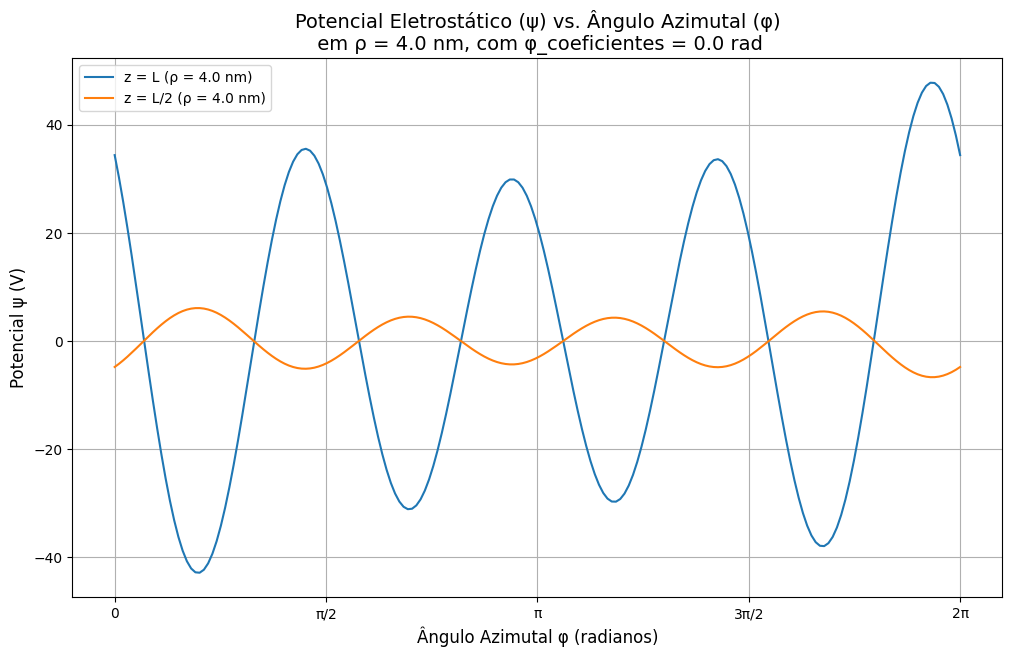

In [8]:
from IPython.display import display, Math         # Importa funcionalidades para exibir equações matemáticas no IPython.
from scipy.special import iv as I_m, kv as K_m    # Importa funções de Bessel modificadas I_m (primeiro tipo) e K_m (segundo tipo).
import numpy as np                                # Importa a biblioteca NumPy para operações numéricas, especialmente com arrays.
import matplotlib.pyplot as plt                   # Importa Matplotlib para a criação de gráficos.

# Configuração da fonte para os gráficos, garantindo melhor compatibilidade de caracteres.
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['axes.formatter.useoffset'] = False

# Parâmetros físicos do sistema.
periodicidade_L = 18e-9                                           # Periodicidade do sistema ao longo do eixo z (metros).
numero_onda_fundamental_c = (2 * np.pi) / periodicidade_L         # Número de onda fundamental associado à periodicidade L.
raio_b = 2e-9                                                     # Raio da interface entre a Região I e a Região II (metros).
raio_d_fronteira_II_III = 3e-9                                    # Raio da interface entre a Região II e a Região III (metros).
raio_rho_limite = 10e-9                                           # Raio máximo considerado para a Região III (metros).
numero_avogadro = 6.02e23                                         # Constante de Avogadro (entidades por mol).
constante_boltzmann = 1.38e-23                                    # Constante de Boltzmann (Joules por Kelvin).
temperatura_kelvin = 298                                          # Temperatura do sistema (Kelvin), ex: 25°C.
energia_termica_Et = constante_boltzmann * temperatura_kelvin     # Energia térmica do sistema (Joules).
concentracao_sal_NM = 8e-6 * numero_avogadro                      # Concentração de sal (íons por metro cúbico), convertida de µM.
constante_dieletrica_agua = 78.54                                 # Constante dielétrica relativa da água.
carga_elementar_e = 1.6e-19                                       # Carga elementar (Coulombs).
permissividade_vacuo = 8.854e-12                                  # Permissividade elétrica do vácuo (Farads por metro).


k_debye_quadrado = (carga_elementar_e**2 * 8 * np.pi**2 * concentracao_sal_NM) / (1000 * constante_dieletrica_agua * energia_termica_Et)
parametro_debye_k = np.sqrt(k_debye_quadrado) # Parâmetro de Debye (inverso do comprimento de Debye).

# Número máximo de termos para as somas nos modos azimutal (m) e axial (n).
max_termos_m = 4 # Afeta a precisão e o tempo de cálculo para o modo m.
max_termos_n = 4 # Afeta a precisão e o tempo de cálculo para o modo n.

# Funções para calcular o potencial eletrostático (ψ) em cada uma das três regiões.
# As funções agora aceitam a coordenada radial (coordenada_rho), o ângulo azimutal (angulo_phi) e a coordenada axial (coordenada_z) como argumentos.

def calcular_potencial_regiao_I(coordenada_rho, angulo_phi, coordenada_z, coeficiente_F_I, m_maximo=max_termos_m, n_maximo=max_termos_n):
    """Calcula o potencial na Região I (0 <= ρ < b)."""
    soma_potencial = 0.0 # Inicializa a soma do potencial.
    # Primeira parte da soma da equação do potencial para a Região I.
    for indice_soma_r in [0, 1]:
        for indice_soma_r_linha in [0, 1]:
            for modo_m in range(m_maximo + 1):
                for modo_n in range(1, n_maximo + 1): # modo_n começa em 1.
                    n_vezes_c = modo_n * numero_onda_fundamental_c
                    # Termos cosseno dependentes de z e phi, com fases controladas por r e r_linha.
                    termo_cosseno_z = np.cos(n_vezes_c * coordenada_z + indice_soma_r * np.pi / 2)
                    termo_cosseno_phi = np.cos(modo_m * angulo_phi + indice_soma_r_linha * np.pi / 2)

                    argumento_bessel_I = n_vezes_c * coordenada_rho
                    # Função de Bessel modificada I_m. Condições para evitar problemas com argumento zero.
                    if argumento_bessel_I < 1e-9 and modo_m > 0: bessel_I = 0
                    elif argumento_bessel_I < 1e-9 and modo_m == 0: bessel_I = 1.0 if argumento_bessel_I == 0 else I_m(modo_m, argumento_bessel_I)
                    else: bessel_I = I_m(modo_m, argumento_bessel_I)

                    soma_potencial += coeficiente_F_I * termo_cosseno_z * termo_cosseno_phi * bessel_I
    # Segunda parte da soma da equação do potencial para a Região I.
    for indice_soma_r in [0, 1]:
        for modo_m in range(1, m_maximo + 1): # modo_m começa em 1.
            termo_cosseno_phi = np.cos(modo_m * angulo_phi + indice_soma_r * np.pi / 2)
            # Termo rho elevado à potência m.
            termo_rho_elevado_m = 0 if coordenada_rho == 0 and modo_m > 0 else coordenada_rho**modo_m
            soma_potencial += termo_cosseno_phi * termo_rho_elevado_m
    return soma_potencial

def calcular_potencial_regiao_II(coordenada_rho, angulo_phi, coordenada_z, m_maximo=max_termos_m, n_maximo=max_termos_n):
    """Calcula o potencial na Região II (b <= ρ < d)."""
    soma_potencial = 0.0 # Inicializa a soma do potencial.
    # Soma sobre os modos m e n para a Região II.
    for indice_soma_r in [0, 1]:
        for indice_soma_r_linha in [0, 1]:
            for modo_m in range(m_maximo + 1):
                for modo_n in range(1, n_maximo + 1): # modo_n começa em 1.
                    n_vezes_c = modo_n * numero_onda_fundamental_c
                    termo_cosseno_z = np.cos(n_vezes_c * coordenada_z + indice_soma_r * np.pi / 2)
                    termo_cosseno_phi = np.cos(modo_m * angulo_phi + indice_soma_r_linha * np.pi / 2)
                    argumento_bessel = n_vezes_c * coordenada_rho

                    # Soma das funções de Bessel modificadas I_m e K_m.
                    # K_m(m,0) é infinito, rho aqui deve ser > 0 (raio_b > 0).
                    if argumento_bessel <= 1e-9: # Tratamento para argumento próximo de zero.
                        bessel_I_val = I_m(modo_m, argumento_bessel)
                        bessel_K_val = np.inf if modo_m == 0 and argumento_bessel == 0 else K_m(modo_m, argumento_bessel) if argumento_bessel > 0 else np.inf
                        soma_bessel = np.sign(termo_cosseno_z * termo_cosseno_phi) * 1e12 if np.isinf(bessel_K_val) else bessel_I_val + bessel_K_val
                    else:
                        soma_bessel = I_m(modo_m, argumento_bessel) + K_m(modo_m, argumento_bessel)

                    soma_potencial += termo_cosseno_z * termo_cosseno_phi * soma_bessel
    return soma_potencial

def calcular_potencial_regiao_III(coordenada_rho, angulo_phi, coordenada_z, coeficiente_F_III, m_maximo=max_termos_m, n_maximo=max_termos_n):
    """Calcula o potencial na Região III (ρ >= d)."""
    soma_potencial = 0.0 # Inicializa a soma do potencial.
    # Soma sobre os modos m e n para a Região III.
    for indice_soma_r in [0, 1]:
        for indice_soma_r_linha in [0, 1]:
            for modo_m in range(m_maximo + 1):
                for modo_n in range(1, n_maximo + 1): # modo_n começa em 1.
                    n_vezes_c = modo_n * numero_onda_fundamental_c
                    parametro_alfa = np.sqrt(n_vezes_c**2 + parametro_debye_k**2) # Parâmetro alfa usado no argumento de K_m.
                    termo_cosseno_z = np.cos(n_vezes_c * coordenada_z + indice_soma_r * np.pi / 2)
                    termo_cosseno_phi = np.cos(modo_m * angulo_phi + indice_soma_r_linha * np.pi / 2)
                    argumento_bessel_K = parametro_alfa * coordenada_rho

                    # Função de Bessel modificada K_m.
                    # K_m(m,0) é infinito, rho aqui deve ser > 0 (raio_d_fronteira_II_III > 0).
                    if argumento_bessel_K <= 1e-9: # Tratamento para argumento próximo de zero.
                        bessel_K = np.inf if modo_m == 0 and argumento_bessel_K == 0 else K_m(modo_m, argumento_bessel_K) if argumento_bessel_K > 0 else np.inf
                        if np.isinf(bessel_K): bessel_K = np.sign(coeficiente_F_III * termo_cosseno_phi * termo_cosseno_z) * 1e12
                    else:
                        bessel_K = K_m(modo_m, argumento_bessel_K)

                    soma_potencial += coeficiente_F_III * termo_cosseno_phi * termo_cosseno_z * bessel_K
    return soma_potencial

# --- Seção de Plotagem: Potencial vs. Ângulo Azimutal ---

# Define o intervalo do ângulo azimutal (phi) para o eixo X do gráfico.
varredura_angular_phi = np.linspace(0, 2 * np.pi, 200)

# Define os valores da coordenada z para os quais as curvas serão plotadas.
coordenadas_z_plot = [periodicidade_L, periodicidade_L / 2]

# Define o valor fixo da coordenada radial (rho) para esta análise.
rho_fixo_plot = 4e-9

# Define um valor fixo para o ângulo phi usado no cálculo dos coeficientes de continuidade F_I e F_III.
phi_fixo_para_coeficientes = 0.0

plt.figure(figsize=(12, 7)) # Cria a figura para o gráfico.

# Loop para calcular e plotar o potencial para cada valor de z especificado.
for z_atual in coordenadas_z_plot:
    # Cálculo dos coeficientes de continuidade F_I e F_III para o z_atual e phi_fixo_para_coeficientes.
    # Coeficiente F_I (continuidade entre Região I e II em rho = b).
    potencial_II_em_b_para_F_I = calcular_potencial_regiao_II(raio_b, phi_fixo_para_coeficientes, z_atual)
    potencial_I_em_b_temp_para_F_I = calcular_potencial_regiao_I(raio_b, phi_fixo_para_coeficientes, z_atual, coeficiente_F_I=1.0)

    # Evita divisão por zero ou por valor muito pequeno.
    if np.abs(potencial_I_em_b_temp_para_F_I) < 1e-9:
        F_I_atual = np.nan
        print(f"Atenção: Denominador para F_I próximo de zero para z = {z_atual:.2e} m")
    else:
        F_I_atual = potencial_II_em_b_para_F_I / potencial_I_em_b_temp_para_F_I

    # Coeficiente F_III (continuidade entre Região II e III em rho = d).
    potencial_II_em_d_para_F_III = calcular_potencial_regiao_II(raio_d_fronteira_II_III, phi_fixo_para_coeficientes, z_atual)
    potencial_III_em_d_temp_para_F_III = calcular_potencial_regiao_III(raio_d_fronteira_II_III, phi_fixo_para_coeficientes, z_atual, coeficiente_F_III=1.0)

    if np.abs(potencial_III_em_d_temp_para_F_III) < 1e-9:
        F_III_atual = np.nan
        print(f"Atenção: Denominador para F_III próximo de zero para z = {z_atual:.2e} m")
    else:
        F_III_atual = potencial_II_em_d_para_F_III / potencial_III_em_d_temp_para_F_III

    valores_potencial_plot = [] # Lista para armazenar os valores de potencial para o gráfico.
    # Loop sobre os valores de angulo_phi para calcular o potencial.
    for valor_phi_plot in varredura_angular_phi:
        # Determina em qual região o rho_fixo_plot se encontra para usar a função de cálculo correta.
        if rho_fixo_plot < raio_b:
            potencial_calculado = calcular_potencial_regiao_I(rho_fixo_plot, valor_phi_plot, z_atual, F_I_atual)
        elif raio_b <= rho_fixo_plot < raio_d_fronteira_II_III:
            potencial_calculado = calcular_potencial_regiao_II(rho_fixo_plot, valor_phi_plot, z_atual)
        else: # rho_fixo_plot >= raio_d_fronteira_II_III
            potencial_calculado = calcular_potencial_regiao_III(rho_fixo_plot, valor_phi_plot, z_atual, F_III_atual)
        valores_potencial_plot.append(potencial_calculado)

    # Define o rótulo da curva no gráfico.
    rotulo_z = "L" if z_atual == periodicidade_L else "L/2"
    plt.plot(varredura_angular_phi, valores_potencial_plot, label=f'z = {rotulo_z} (ρ = {rho_fixo_plot*1e9:.1f} nm)')

# Configurações finais do gráfico.
plt.title(f'Potencial Eletrostático (ψ) vs. Ângulo Azimutal (φ)\n em ρ = {rho_fixo_plot*1e9:.1f} nm, com φ_coeficientes = {phi_fixo_para_coeficientes:.1f} rad', fontsize=14)
plt.xlabel('Ângulo Azimutal φ (radianos)', fontsize=12)
plt.ylabel('Potencial ψ (V)', fontsize=12)
# Define as marcações do eixo x em termos de múltiplos de pi.
plt.xticks(np.array([0, 0.5, 1, 1.5, 2])*np.pi, ['0', 'π/2', 'π', '3π/2', '2π'])
plt.legend() # Exibe a legenda do gráfico.
plt.grid(True) # Adiciona uma grade ao gráfico para melhor visualização.
plt.show() # Mostra o gráfico.